In [180]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt

### Download data from kaggle

In [181]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

### Choose the block name and print it

In [182]:
idx = 99
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000231,2011-12-02,0.076,0.064,0.005,0.000,0.061,0.009,0.000,0.051,...,0.052,0.103,0.210,0.062,0.065,0.109,0.048,0.520,0.646,0.052
1,MAC000231,2011-12-03,0.000,0.033,0.048,0.000,0.011,0.055,0.007,0.018,...,0.000,0.422,0.510,0.085,0.146,0.484,0.135,0.310,0.105,0.068
2,MAC000231,2011-12-04,0.046,0.023,0.000,0.055,0.209,0.036,0.053,0.001,...,0.088,0.293,0.306,0.111,0.278,0.614,0.723,0.176,0.101,0.155
3,MAC000231,2011-12-05,0.000,0.062,0.002,0.016,0.045,0.000,0.035,0.027,...,0.069,0.719,0.637,0.625,0.652,0.313,0.593,0.766,0.299,0.000
4,MAC000231,2011-12-06,0.039,0.030,0.000,0.036,0.033,0.000,0.028,0.040,...,0.094,0.082,0.106,0.047,0.058,0.567,0.616,0.529,0.112,0.006


### This function is used to fill the gaps between days (missing days)

In [183]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [184]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [185]:
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000231,2011-12-02,0.076,0.064,0.005,0.000,0.061,0.009,0.000,0.051,...,0.052,0.103,0.210,0.062,0.065,0.109,0.048,0.520,0.646,0.052
1,MAC000231,2011-12-03,0.000,0.033,0.048,0.000,0.011,0.055,0.007,0.018,...,0.000,0.422,0.510,0.085,0.146,0.484,0.135,0.310,0.105,0.068
2,MAC000231,2011-12-04,0.046,0.023,0.000,0.055,0.209,0.036,0.053,0.001,...,0.088,0.293,0.306,0.111,0.278,0.614,0.723,0.176,0.101,0.155
3,MAC000231,2011-12-05,0.000,0.062,0.002,0.016,0.045,0.000,0.035,0.027,...,0.069,0.719,0.637,0.625,0.652,0.313,0.593,0.766,0.299,0.000
4,MAC000231,2011-12-06,0.039,0.030,0.000,0.036,0.033,0.000,0.028,0.040,...,0.094,0.082,0.106,0.047,0.058,0.567,0.616,0.529,0.112,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33220,MAC005019,2014-02-23,0.212,0.170,0.145,0.228,0.123,0.081,0.130,0.079,...,0.092,0.102,0.081,0.111,0.072,0.135,0.116,0.133,0.092,0.067
33221,MAC005019,2014-02-24,0.064,0.107,0.107,0.122,0.095,0.132,0.085,0.137,...,0.103,0.106,0.103,0.099,0.072,0.097,0.057,0.088,0.046,0.077
33222,MAC005019,2014-02-25,0.053,0.067,0.060,0.076,0.051,0.070,0.033,0.061,...,0.805,1.235,1.243,1.150,0.547,0.418,0.125,0.076,0.041,0.090
33223,MAC005019,2014-02-26,0.045,0.049,0.077,0.032,0.051,0.065,0.042,0.039,...,0.480,0.271,0.214,0.149,0.116,0.165,0.058,0.060,0.077,0.045


In [186]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-186-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


,day,LCLid,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2011-12-02,MAC000231,0.076,0.064,0.005,0.000,0.061,0.009,0.000,0.051,...,0.052,0.103,0.210,0.062,0.065,0.109,0.048,0.520,0.646,0.052
1,2011-12-03,MAC000231,0.000,0.033,0.048,0.000,0.011,0.055,0.007,0.018,...,0.000,0.422,0.510,0.085,0.146,0.484,0.135,0.310,0.105,0.068
2,2011-12-04,MAC000231,0.046,0.023,0.000,0.055,0.209,0.036,0.053,0.001,...,0.088,0.293,0.306,0.111,0.278,0.614,0.723,0.176,0.101,0.155
3,2011-12-05,MAC000231,0.000,0.062,0.002,0.016,0.045,0.000,0.035,0.027,...,0.069,0.719,0.637,0.625,0.652,0.313,0.593,0.766,0.299,0.000
4,2011-12-06,MAC000231,0.039,0.030,0.000,0.036,0.033,0.000,0.028,0.040,...,0.094,0.082,0.106,0.047,0.058,0.567,0.616,0.529,0.112,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33446,2014-02-23,MAC005019,0.212,0.170,0.145,0.228,0.123,0.081,0.130,0.079,...,0.092,0.102,0.081,0.111,0.072,0.135,0.116,0.133,0.092,0.067
33447,2014-02-24,MAC005019,0.064,0.107,0.107,0.122,0.095,0.132,0.085,0.137,...,0.103,0.106,0.103,0.099,0.072,0.097,0.057,0.088,0.046,0.077
33448,2014-02-25,MAC005019,0.053,0.067,0.060,0.076,0.051,0.070,0.033,0.061,...,0.805,1.235,1.243,1.150,0.547,0.418,0.125,0.076,0.041,0.090
33449,2014-02-26,MAC005019,0.045,0.049,0.077,0.032,0.051,0.065,0.042,0.039,...,0.480,0.271,0.214,0.149,0.116,0.165,0.058,0.060,0.077,0.045


In [187]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-187-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


,LCLid,timestamp,energy_consumption,frequency,serie_length
0,MAC000231,2011-12-02 00:00:00,0.076,30min,38880
1,MAC000231,2011-12-02 00:30:00,0.064,30min,38880
2,MAC000231,2011-12-02 01:00:00,0.005,30min,38880
3,MAC000231,2011-12-02 01:30:00,0.000,30min,38880
4,MAC000231,2011-12-02 02:00:00,0.061,30min,38880
...,...,...,...,...,...
1594795,MAC005019,2014-02-20 21:30:00,0.154,30min,30720
1594796,MAC005019,2014-02-20 22:00:00,0.129,30min,30720
1594797,MAC005019,2014-02-20 22:30:00,0.095,30min,30720
1594798,MAC005019,2014-02-20 23:00:00,0.061,30min,30720


In [188]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col

In [189]:
ts_df = expand_form[expand_form.LCLid=="MAC005019"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [190]:
ts_df

,LCLid,energy_consumption,frequency,serie_length
timestamp,,,,
2012-05-22 00:00:00,MAC005019,0.101,30min,30720
2012-05-22 00:30:00,MAC005019,0.110,30min,30720
2012-05-22 01:00:00,MAC005019,0.078,30min,30720
2012-05-22 01:30:00,MAC005019,0.063,30min,30720
2012-05-22 02:00:00,MAC005019,0.109,30min,30720
...,...,...,...,...
2014-02-20 21:30:00,MAC005019,0.154,30min,30720
2014-02-20 22:00:00,MAC005019,0.129,30min,30720
2014-02-20 22:30:00,MAC005019,0.095,30min,30720


In [191]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [192]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [193]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [194]:
ts_df

,LCLid,energy_consumption,frequency,serie_length,weekday_name,weekday,week,day,hour,date,month,month_name,year
timestamp,,,,,,,,,,,,,
2012-05-22 00:00:00,MAC005019,0.101,30min,30720,Tuesday,1,21,22,0,2012-05-22,5,May,2012
2012-05-22 00:30:00,MAC005019,0.110,30min,30720,Tuesday,1,21,22,0,2012-05-22,5,May,2012
2012-05-22 01:00:00,MAC005019,0.078,30min,30720,Tuesday,1,21,22,1,2012-05-22,5,May,2012
2012-05-22 01:30:00,MAC005019,0.063,30min,30720,Tuesday,1,21,22,1,2012-05-22,5,May,2012
2012-05-22 02:00:00,MAC005019,0.109,30min,30720,Tuesday,1,21,22,2,2012-05-22,5,May,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-20 21:30:00,MAC005019,0.154,30min,30720,Thursday,3,8,20,21,2014-02-20,2,February,2014
2014-02-20 22:00:00,MAC005019,0.129,30min,30720,Thursday,3,8,20,22,2014-02-20,2,February,2014
2014-02-20 22:30:00,MAC005019,0.095,30min,30720,Thursday,3,8,20,22,2014-02-20,2,February,2014


In [231]:
monthly_df = ts_df.groupby(["year","month"])[['energy_consumption']].mean()
monthly_df

energy_consumption
year month                    
2012 5                0.190027
     6                0.221415
     7                0.179376
     8                0.168498
     9                0.143710
     10               0.156481
     11               0.187370
     12               0.196165
2013 1                0.195402
     2                0.180339
     3                0.183905
     4                0.161231
     5                0.132437
     6                0.142083
     7                0.124116
     8                0.125797
     9                0.156013
     10               0.141212
     11               0.148549
     12               0.202827
2014 1                0.152204
     2                0.154691

In [232]:
monthly_df = monthly_df.reset_index()
monthly_df['timestamp'] = monthly_df.apply(
    lambda row: pd.Timestamp(
        year=int(row['year']),
        month=int(row['month']),
        day=1
    ),
    axis=1
)
monthly_df = monthly_df.set_index('timestamp').sort_index()
monthly_df

,year,month,energy_consumption
timestamp,,,
2012-05-01,2012,5,0.190027
2012-06-01,2012,6,0.221415
2012-07-01,2012,7,0.179376
2012-08-01,2012,8,0.168498
2012-09-01,2012,9,0.143710
2012-10-01,2012,10,0.156481
2012-11-01,2012,11,0.187370
2012-12-01,2012,12,0.196165
2013-01-01,2013,1,0.195402


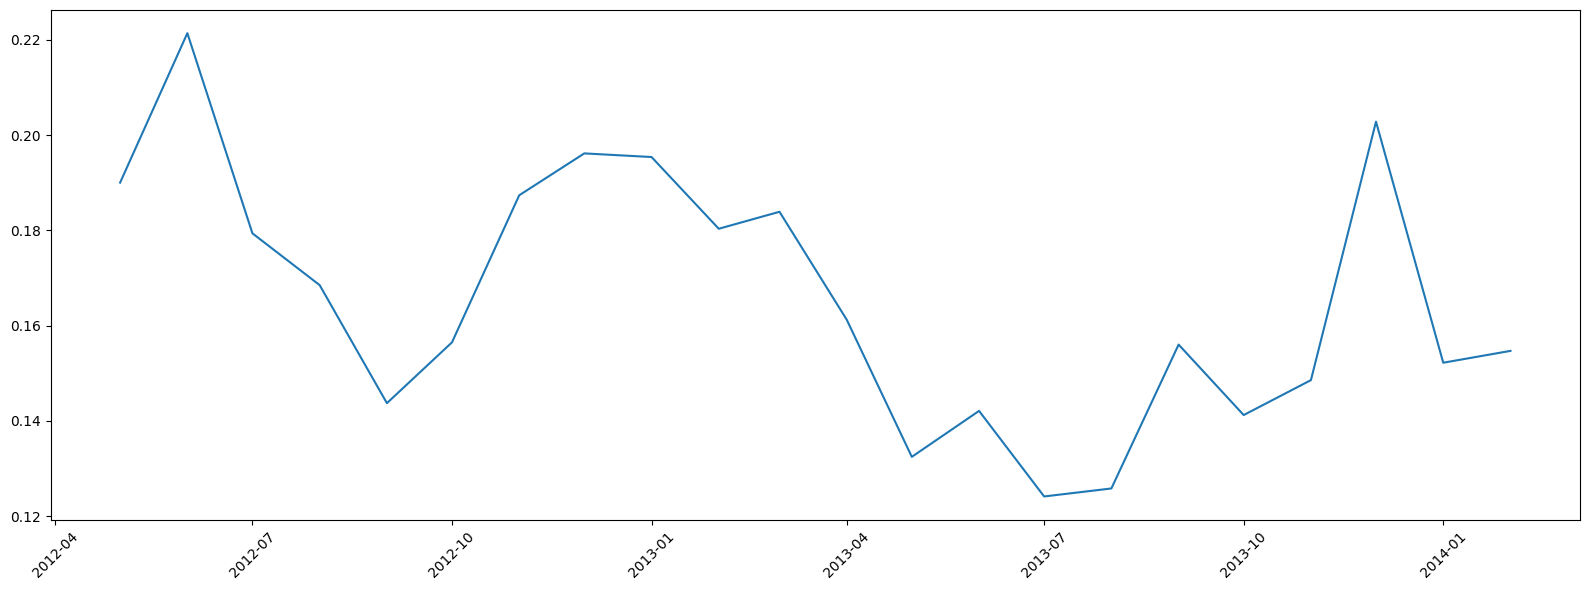

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.plot(monthly_df.index, monthly_df["energy_consumption"])

plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

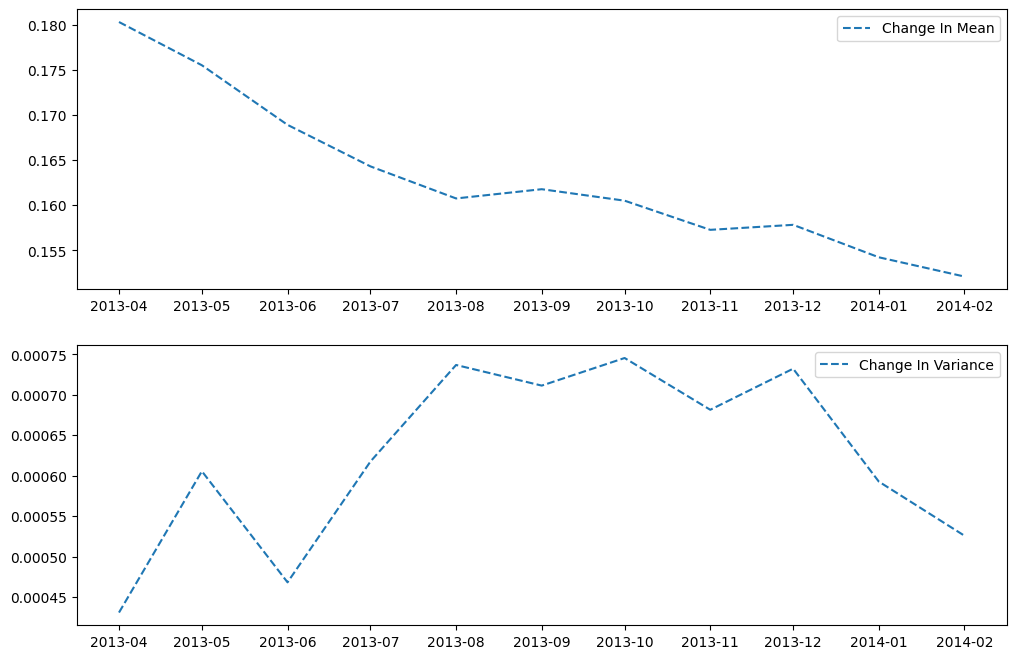

In [209]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(monthly_df.index, monthly_df['energy_consumption'].rolling(window=12).mean() , label='Change In Mean', linestyle='--')
ax[1].plot(monthly_df.index, monthly_df['energy_consumption'].rolling(window=12).var() , label='Change In Variance', linestyle='--')

ax[0].legend()
ax[1].legend()
plt.show()

### There is change in mean only not in variance so won't make log

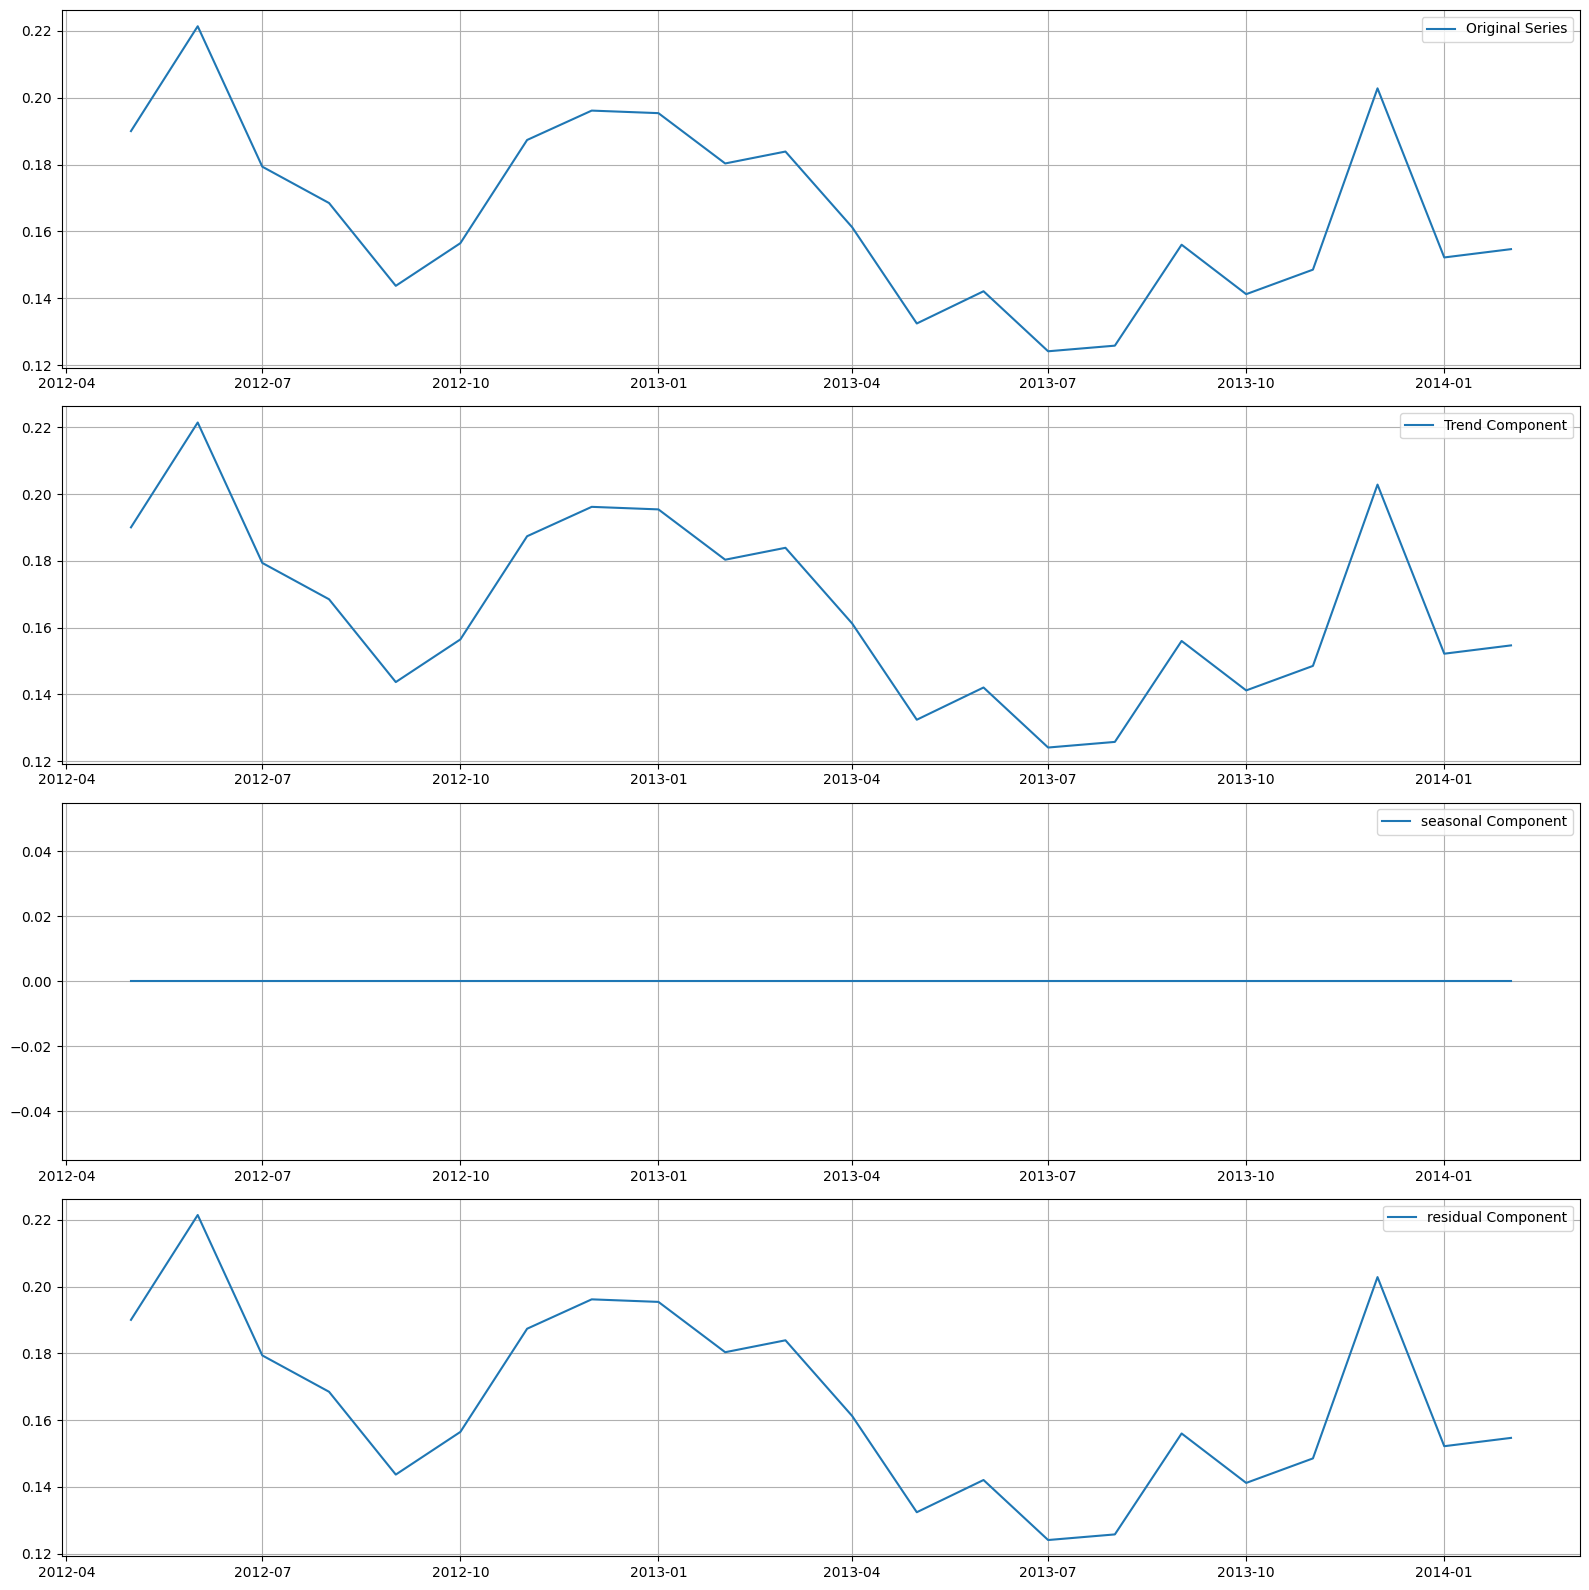

In [233]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

trend = lowess(monthly_df['energy_consumption'] , range(len(monthly_df)), frac=0.05)[:, 1]
detrended_series = monthly_df['energy_consumption'] - trend

time = np.arange(len(monthly_df['energy_consumption'] ))
seasonal = np.zeros_like(monthly_df['energy_consumption'] )
for i in range(1, 3+ 1):
    seasonal += (np.sin(2 * np.pi * i * time / (1)) +
                np.cos(2 * np.pi * i * time / (1)))

seasonal = (seasonal - seasonal.min()) / (seasonal.max() - seasonal.min())
seasonal = seasonal * detrended_series.std()

residual = detrended_series - seasonal
trend = pd.Series(index=monthly_df.index, data=trend)
seasonal = pd.Series(index=monthly_df.index, data=seasonal)
residual = pd.Series(index=monthly_df.index, data=residual)

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

axs[0].plot(monthly_df.index, monthly_df['energy_consumption'], label='Original Series')


axs[1].plot(monthly_df.index, trend, label='Trend Component')
axs[2].plot(monthly_df.index, seasonal, label='seasonal Component')
axs[3].plot(monthly_df.index, trend, label='residual Component')

for ax in axs:
    ax.legend()
    ax.grid()
fig.tight_layout()

### There is no seasonality so i will use another technique to detrending

In [237]:
trend = (
    monthly_df['energy_consumption']
    .rolling(window=12, center=True)
    .mean()
    .ffill()
    .bfill()
)

trend

,energy_consumption
timestamp,
2012-05-01,0.180327
2012-06-01,0.180327
2012-07-01,0.180327
2012-08-01,0.180327
2012-09-01,0.180327
2012-10-01,0.180327
2012-11-01,0.180327
2012-12-01,0.175527
2013-01-01,0.168916


In [238]:
monthly_df['energy_consumption_decomposed'] = monthly_df['energy_consumption'] -trend

In [240]:
from statsmodels.tsa.stattools import adfuller, kpss

adfullers_test, adf_pval , _, __, ___, ____= adfuller(monthly_df['energy_consumption_decomposed'])
kpss_test, kpss_pval, _, __ = kpss(monthly_df['energy_consumption_decomposed'])

if adf_pval < 0.05:
  print("pValue: ", adf_pval)
  print('The series is stationary')
else:
  print('The series is not stationary')

if kpss_pval < 0.05:
  print('The series is not stationary')
else:
  print("pValue: ", kpss_pval)
  print('The series is stationary')

pValue:  0.027116248257046234
The series is stationary
pValue:  0.1
The series is stationary


<ipython-input-240-4771c681b85f>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test, kpss_pval, _, __ = kpss(monthly_df['energy_consumption_decomposed'])


### here after decomposition data now is stationary so we can use ml models and get a good predictions

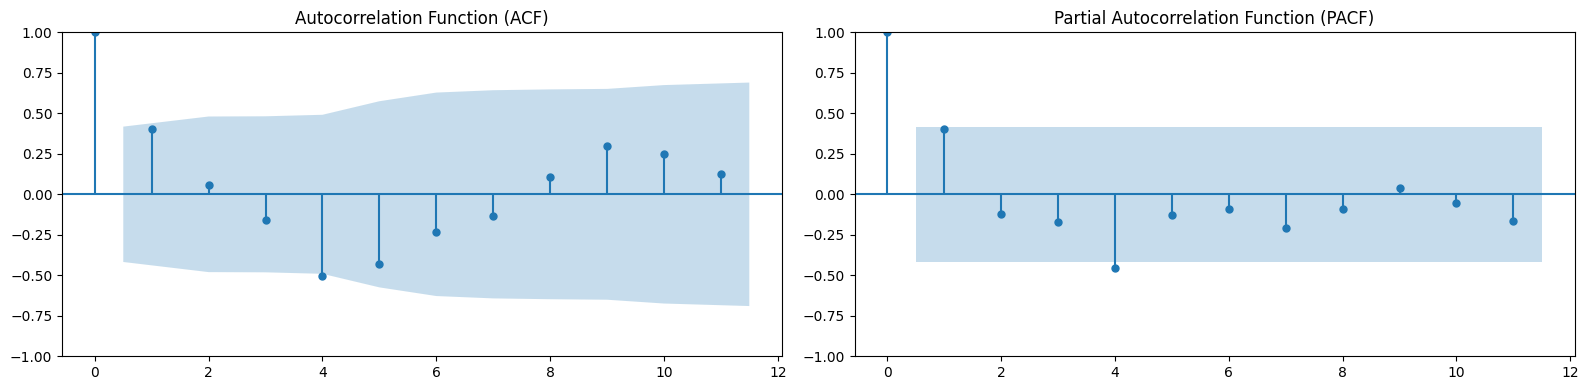

In [241]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(monthly_df['energy_consumption_decomposed'], ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(monthly_df['energy_consumption_decomposed'], ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

### After visualize the autocorrelation and PACF i find thet it correlated using 1 lag

### First Approach : Using Delay Embedding with Two Lags

In [242]:
tau = 1
monthly_df['Lag_1'] = monthly_df['energy_consumption_decomposed'].shift(tau)

monthly_df.head()

,year,month,energy_consumption,energy_consumption_decomposed,Lag_1
timestamp,,,,,
2012-05-01,2012,5,0.190027,0.009700,NaN
2012-06-01,2012,6,0.221415,0.041089,0.009700
2012-07-01,2012,7,0.179376,-0.000950,0.041089
2012-08-01,2012,8,0.168498,-0.011829,-0.000950
2012-09-01,2012,9,0.143710,-0.036617,-0.011829


### Using Random Forest Algorithm Without Bootstrap

In [243]:
from sklearn.ensemble import RandomForestRegressor
X = monthly_df[['Lag_1']]
y = monthly_df['energy_consumption_decomposed']

rf_dt_ds_model = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [244]:
monthly_df['y_hat_rf'] = rf_dt_ds_model.predict(X) + trend

In [245]:
monthly_df

,year,month,energy_consumption,energy_consumption_decomposed,Lag_1,y_hat_rf
timestamp,,,,,,
2012-05-01,2012,5,0.190027,0.009700,NaN,0.193191
2012-06-01,2012,6,0.221415,0.041089,0.009700,0.221415
2012-07-01,2012,7,0.179376,-0.000950,0.041089,0.179376
2012-08-01,2012,8,0.168498,-0.011829,-0.000950,0.168498
2012-09-01,2012,9,0.143710,-0.036617,-0.011829,0.143710
2012-10-01,2012,10,0.156481,-0.023846,-0.036617,0.156481
2012-11-01,2012,11,0.187370,0.007044,-0.023846,0.187370
2012-12-01,2012,12,0.196165,0.020637,0.007044,0.196165
2013-01-01,2013,1,0.195402,0.026485,0.020637,0.195402


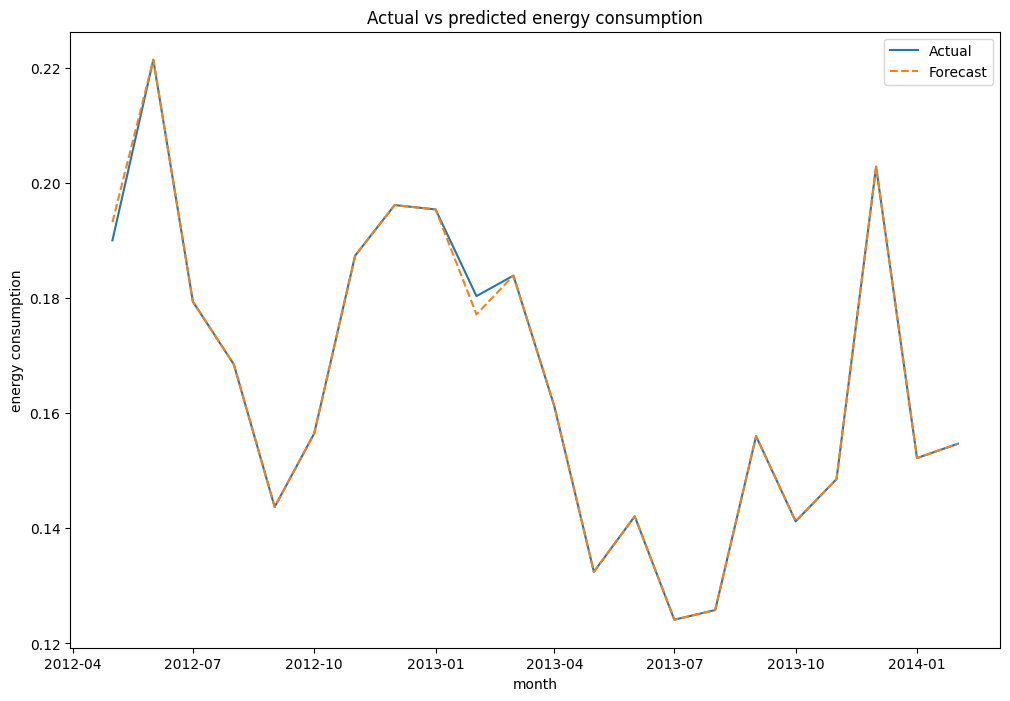

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(monthly_df.index, monthly_df['energy_consumption'], label='Actual')
ax.plot(monthly_df.index, monthly_df['y_hat_rf'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('month')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

### The fit (predictions) is so good because we make a good analysis :
1- trend estimation using rolling making the data stationary

3- find the effected Lags using PACF

4- making the Delay Embedding  

3- using thr Random Forest Algo without bootstrap

4- finally add the seasonality and decomposition again  

In [247]:
h = 3
def forecast_future_ds(model, data, trend, steps=3, freq='M'):
    # Starting with the last known lag values
    last_lag1 = data['Lag_1'].iloc[-1]

    # To store future predictions
    future_predictions = []

    # Fill NaN values in the trend and seasonal components, if any, at the end
    trend =trend.dropna()

    # We can take the last known trend change to extrapolate the trend
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Format the input with the correct column names
        input_df = pd.DataFrame([[last_lag1]], columns=['Lag_1'])

        # Predict the next value
        next_value_pred = model.predict(input_df)[0]

        # Update lag values
        last_lag1 = next_value_pred

        # Add back the trend and seasonal components
        # Extrapolate the trend
        next_trend = last_known_trend + trend_diff * (step + 1)

        next_value_pred += next_trend

        future_predictions.append(next_value_pred)

    # Create a date range for the future predictions
    last_date = data.index[-1]

    # Generate future dates
    future_dates = pd.date_range(
        start=last_date + pd.DateOffset(1, freq),
        periods=steps,
        freq=freq
    )
    #future_dates = pd.date_range(start=last_date + pd.DateOffset(1, freq), periods=h, freq=freq)
    future_df = pd.DataFrame(index=future_dates, data=future_predictions, columns=["RF_bootstrapFalse_forecast"])


    return future_df

In [266]:
future_df = forecast_future_ds(rf_dt_ds_model, monthly_df,  trend , h, freq='MS')

In [267]:
future_df

,RF_bootstrapFalse_forecast
2014-03-01,0.154691
2014-04-01,0.141212
2014-05-01,0.148549


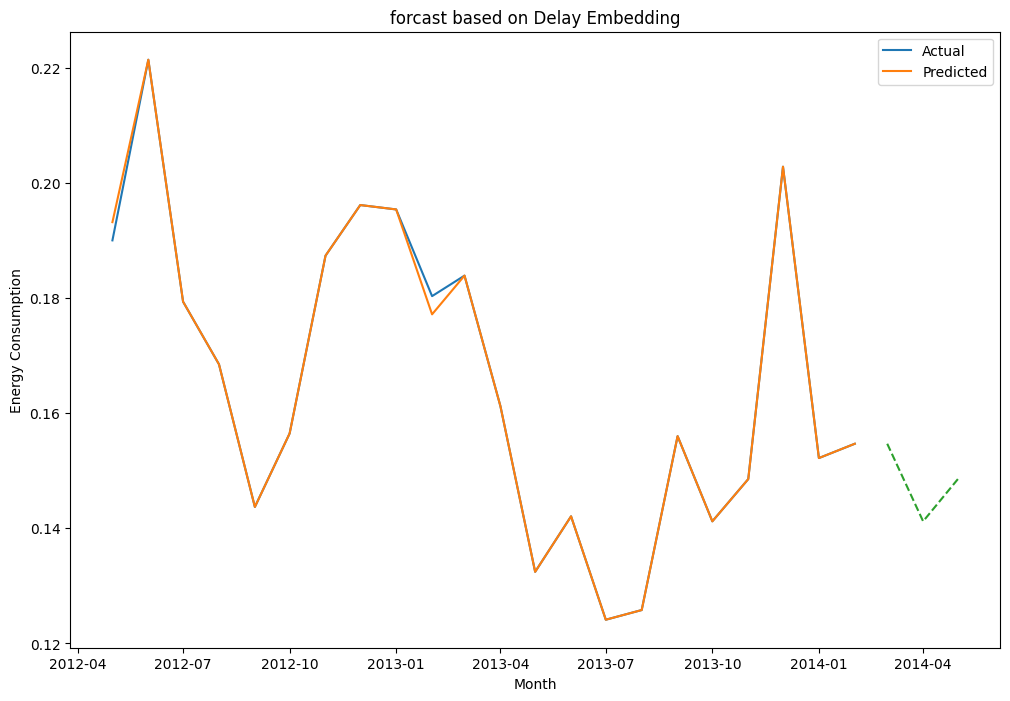

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(monthly_df.index, monthly_df['energy_consumption'], label='Actual')
ax.plot(monthly_df.index, monthly_df['y_hat_rf'], label='Predicted')
ax.plot(future_df.index, future_df['RF_bootstrapFalse_forecast'],linestyle='--')

ax.set_title(f'forcast based on Delay Embedding')
ax.set_xlabel('Month')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

### Second Approach : Using Temporal Embedding

In [264]:
import numpy as np

def add_cyclic_features(df):

    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    return df

monthly_df_full_embedding = add_cyclic_features(monthly_df)

In [265]:
monthly_df_full_embedding

,year,month,energy_consumption,energy_consumption_decomposed,Lag_1,y_hat_rf,month_sin
timestamp,,,,,,,
2012-05-01,2012,5,0.190027,0.009700,NaN,0.193191,5.000000e-01
2012-06-01,2012,6,0.221415,0.041089,0.009700,0.221415,1.224647e-16
2012-07-01,2012,7,0.179376,-0.000950,0.041089,0.179376,-5.000000e-01
2012-08-01,2012,8,0.168498,-0.011829,-0.000950,0.168498,-8.660254e-01
2012-09-01,2012,9,0.143710,-0.036617,-0.011829,0.143710,-1.000000e+00
2012-10-01,2012,10,0.156481,-0.023846,-0.036617,0.156481,-8.660254e-01
2012-11-01,2012,11,0.187370,0.007044,-0.023846,0.187370,-5.000000e-01
2012-12-01,2012,12,0.196165,0.020637,0.007044,0.196165,-2.449294e-16
2013-01-01,2013,1,0.195402,0.026485,0.020637,0.195402,5.000000e-01


In [270]:
from sklearn.ensemble import RandomForestRegressor
X = monthly_df_full_embedding[['month_sin' , 'year']]
y = monthly_df_full_embedding['energy_consumption_decomposed']

rf_dt_ds_model_Temporal = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model_Temporal.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [271]:
monthly_df_full_embedding['y_hat_rf_temporal'] = rf_dt_ds_model_Temporal.predict(X) + trend + seasonal

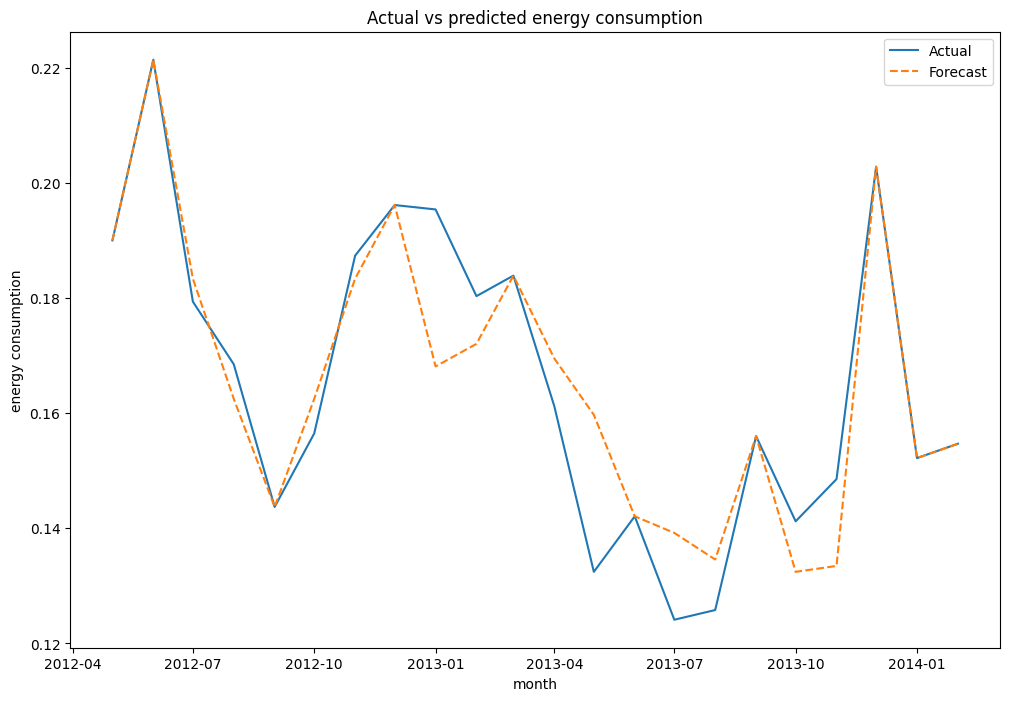

In [272]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['y_hat_rf_temporal'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('month')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

### Forcasting using Temporal embedding

In [275]:
def forecast_future_weekly(model, last_known_data, trend, steps=3):
    """
    Forecast future weekly values with temporal features.

    Parameters:
    - model: Trained forecasting model (expects ['week_sin', 'month_sin', 'year'])
    - last_known_data: Last row of data with temporal features
    - trend: Trend component from decomposition
    - seasonal: Seasonal component from decomposition
    - steps: Number of weeks to forecast

    Returns:
    - DataFrame with weekly forecasts and proper DateTimeIndex
    """
    forecasts = []
    timestamps = []

    # Extract initial time components
    month = int(last_known_data['month'])
    year = int(last_known_data['year'])

    # Get last timestamp from historical data
    last_timestamp = monthly_df_full_embedding.index[-1]

    # Clean components
    trend = trend.dropna()

    # Compute trend difference and get last trend value
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Calculate cyclical features
        month_sin = np.sin(2 * np.pi * month / 12)

        # Build features DataFrame
        features_df = pd.DataFrame({
            'month_sin': [month_sin],
            'year': [year]
        })

        # Predict base value
        base_pred = model.predict(features_df)[0]

        # Add components
        current_trend = last_known_trend + trend_diff * (step + 1)
        full_prediction = base_pred + current_trend

        forecasts.append(full_prediction)

        timestamps.append(last_timestamp + pd.DateOffset(months=step + 1))


        # Update calendar components
        month += 1
        if month > 12:
            month = 1
            year += 1

    # Create result DataFrame
    forecast_df = pd.DataFrame(
        forecasts,
        index=pd.DatetimeIndex(timestamps),
        columns=["monthly_forecast"]
    )

    return forecast_df

# Get last known data point with weekly features
last_known_data = monthly_df_full_embedding.iloc[-1][['year', 'month', 'month_sin']].copy()

# Generate 8-week forecast (2 months)
future_predictions = forecast_future_weekly(rf_dt_ds_model_Temporal,last_known_data,trend,steps=3)

In [276]:
future_predictions

,monthly_forecast
2014-03-01,0.154691
2014-04-01,0.175241
2014-05-01,0.154691


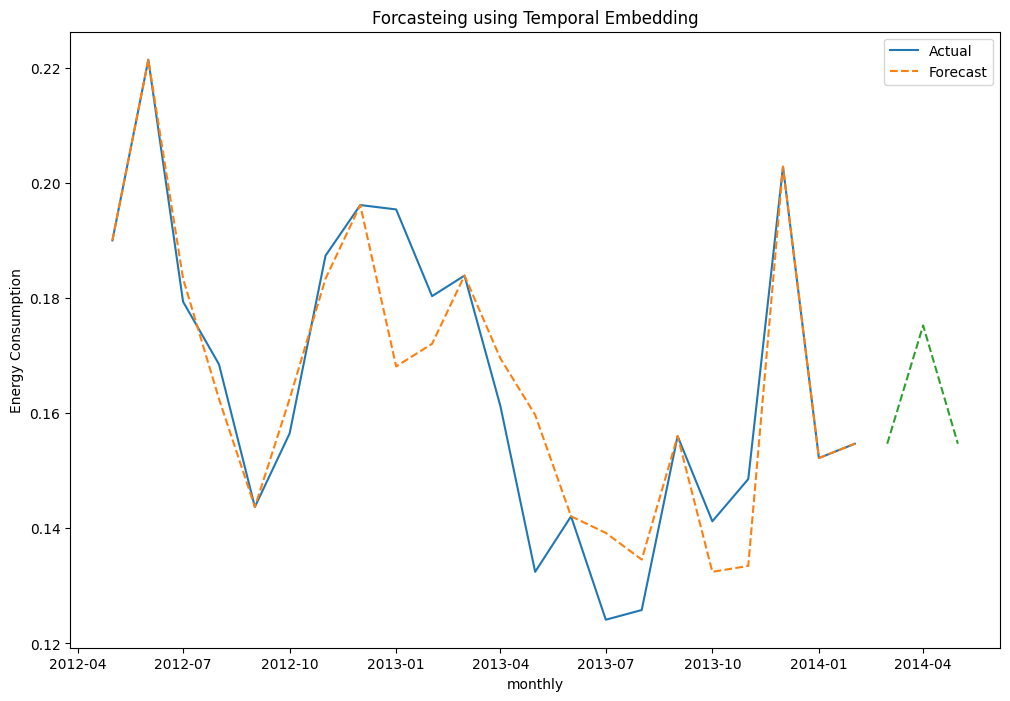

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['y_hat_rf_temporal'], label='Forecast', linestyle='--')
future_predictions
ax.plot(future_predictions.index, future_predictions['monthly_forecast'],linestyle='--')

ax.set_title(f'Forcasteing using Temporal Embedding')
ax.set_xlabel('monthly')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

### Third Approach : Using Combination between Delay Embedding with Two Lags and Temporal Embedding

In [279]:
from sklearn.ensemble import RandomForestRegressor
X = monthly_df_full_embedding[['Lag_1','year', 'month_sin']]
y = monthly_df_full_embedding['energy_consumption_decomposed']

rf_dt_ds_model_Temporal_Delay = RandomForestRegressor(n_estimators=100, bootstrap=False)
rf_dt_ds_model_Temporal_Delay.fit(X, y)

RandomForestRegressor(bootstrap=False)

In [287]:
monthly_df_full_embedding['y_hat_rf_temporal_delay'] = rf_dt_ds_model_Temporal_Delay.predict(X) + trend

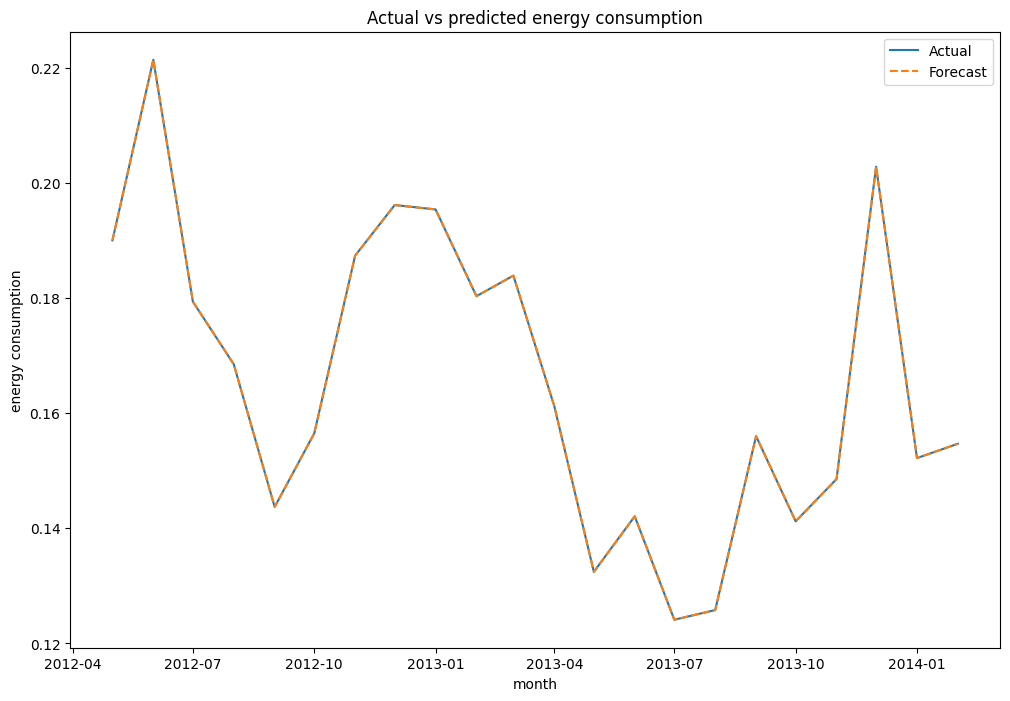

In [288]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['y_hat_rf_temporal_delay'], label='Forecast', linestyle='--')
ax.set_title('Actual vs predicted energy consumption')
ax.set_xlabel('month')
ax.set_ylabel('energy consumption')
ax.legend()
plt.show()

In [289]:
def combined_weekly_forecast(model, data, last_known_data, trend, steps=4):
    """
    Combined weekly forecast using lag features and temporal features

    Parameters:
    - model: Trained model (expects ['Lag_1', 'year', 'week_sin', 'month_sin'])
    - data: Historical data with Lag_1 column and DateTimeIndex
    - last_known_data: Last row with ['year', 'month', 'week', 'week_sin', 'month_sin']
    - trend: Trend component
    - seasonal: Seasonal component (weekly)
    - steps: Number of weeks to forecast

    Returns:
    - DataFrame with weekly forecasts and DateTimeIndex
    """
    forecasts = []
    timestamps = []

    # Initialize values
    last_lag1 = data['Lag_1'].iloc[-1]
    month = int(last_known_data['month'])
    year = int(last_known_data['year'])
    last_timestamp = data.index[-1]

    # Prepare components
    trend = trend.dropna()
    trend_diff = trend.iloc[-1] - trend.iloc[-2]
    last_known_trend = trend.iloc[-1]

    for step in range(steps):
        # Calculate cyclical features
        month_sin = np.sin(2 * np.pi * month / 12)

        # Create input features
        features = {
            'Lag_1': last_lag1,
            'year': year,
            'month_sin': month_sin
        }

        # Make prediction
        base_pred = model.predict(pd.DataFrame([features]))[0]

        # Add components
        current_trend = last_known_trend + trend_diff * (step + 1)
        full_pred = base_pred + current_trend

        forecasts.append(full_pred)

        # Update for next iteration
        last_lag1 = base_pred

        timestamps.append(last_timestamp + pd.DateOffset(months=step + 1))


        # Update calendar components
        month += 1
        if month > 12:
            month = 1
            year += 1

    return pd.DataFrame(
        forecasts,
        index=pd.DatetimeIndex(timestamps),
        columns=['monthly_forecast']
    )


# =============================================
# Usage Example
# =============================================
# Get last known data
last_known_data = monthly_df_full_embedding.iloc[-1][['year', 'month', 'month_sin']].copy()

future_predictions = combined_weekly_forecast(rf_dt_ds_model_Temporal_Delay, monthly_df_full_embedding ,last_known_data, trend, steps=3)

In [290]:
future_predictions

,monthly_forecast
2014-03-01,0.154691
2014-04-01,0.154691
2014-05-01,0.154691


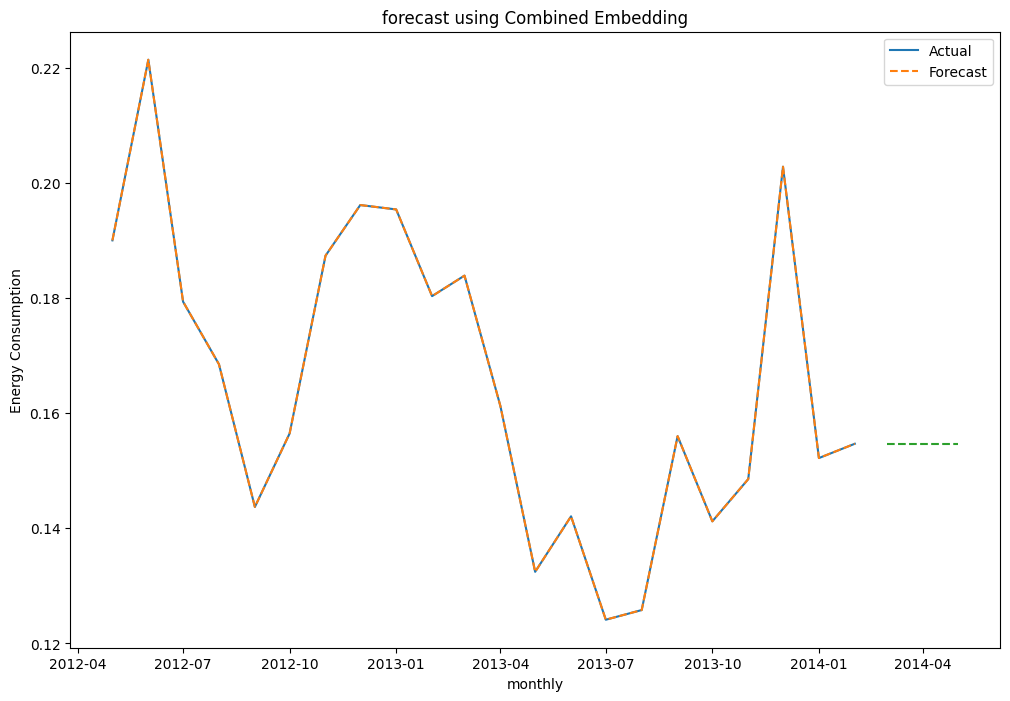

In [291]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['energy_consumption'], label='Actual')
ax.plot(monthly_df_full_embedding.index, monthly_df_full_embedding['y_hat_rf_temporal_delay'], label='Forecast', linestyle='--')

ax.plot(future_predictions.index, future_predictions['monthly_forecast'],linestyle='--')

ax.set_title(f'forecast using Combined Embedding')
ax.set_xlabel('monthly')
ax.set_ylabel('Energy Consumption')
ax.legend()
plt.show()

Combined :

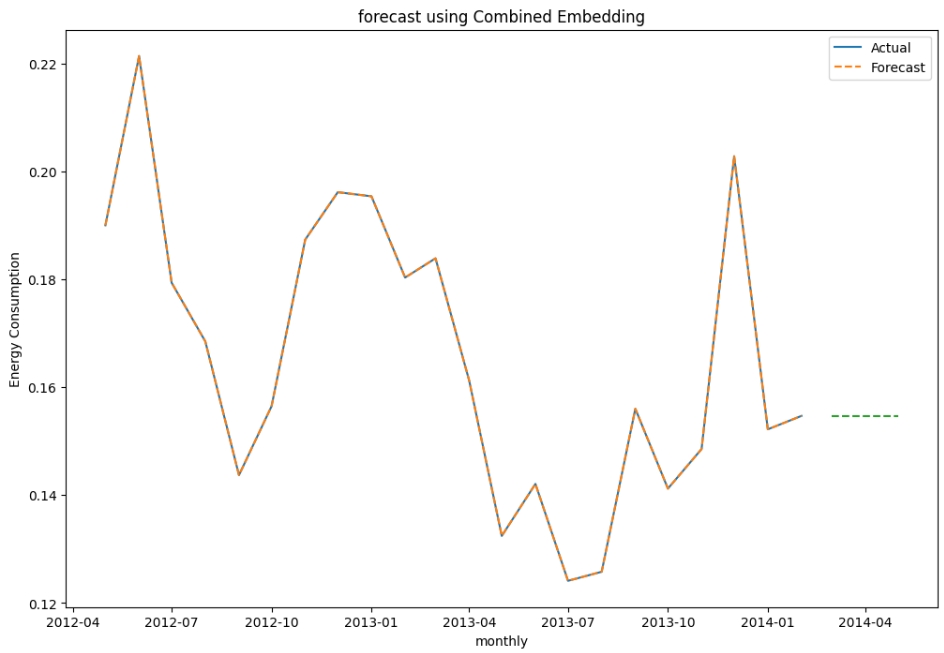

temoral :

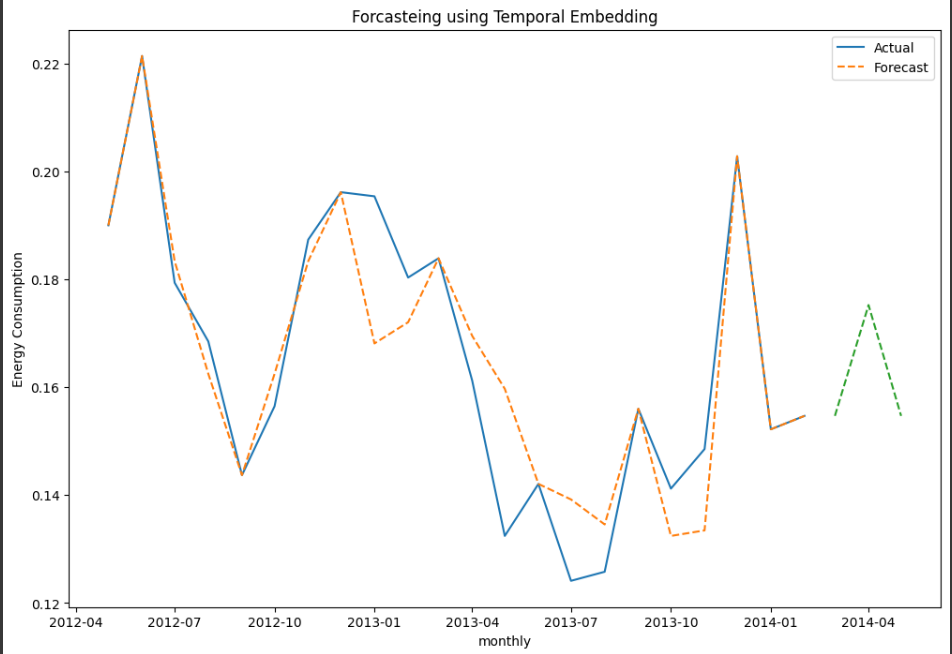

delay:

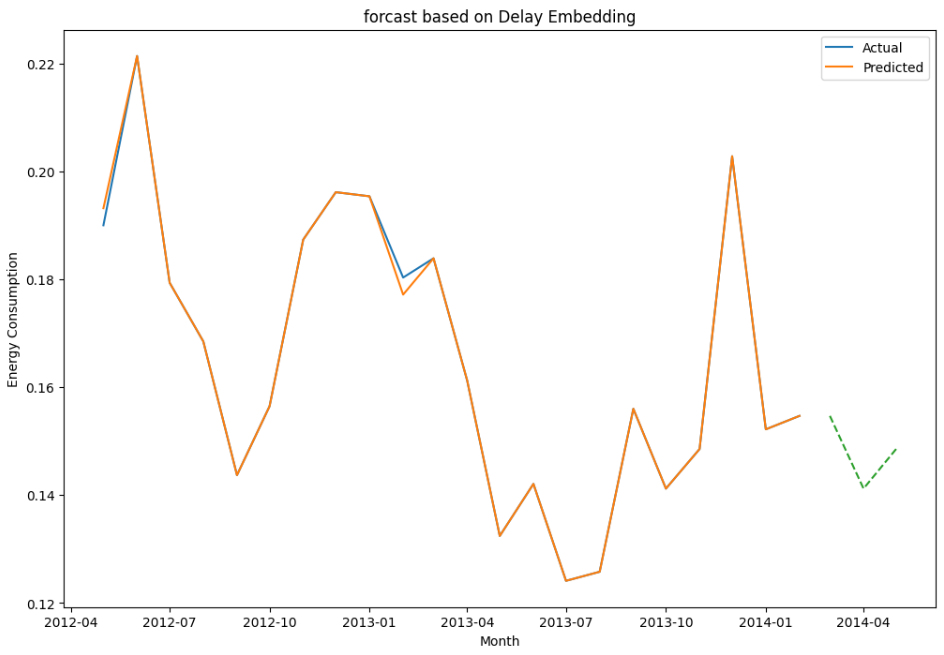

### It seems that delay and combined techniques are better than using only temporal